# Install `torch-geometric`

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.3 MB/s eta 0:00:00


# Import Libraries

In [3]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from sklearn.utils.class_weight import compute_class_weight

# Load the whole dataset and check the target distribution

Extracting /tmp/PPI/ppi.zip
Processing...
Done!


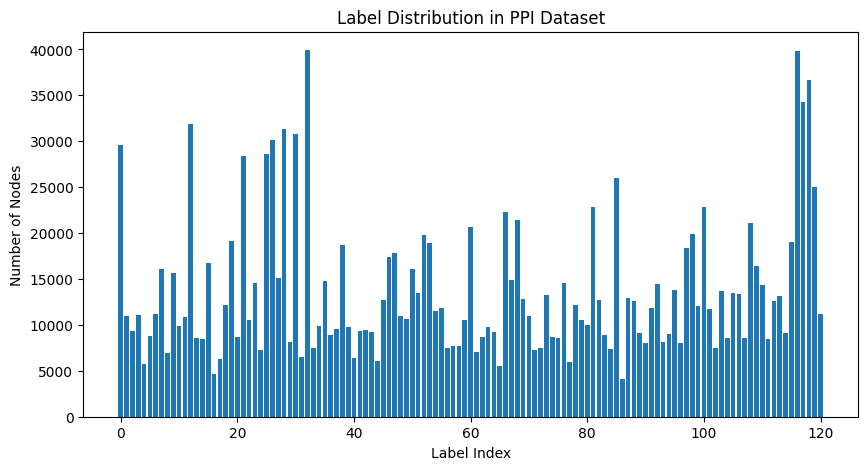

In [4]:
data = PPI(root='/tmp/PPI')
label_counts = data.y.sum(dim=0).numpy()

plt.figure(figsize=(10, 5))
plt.bar(range(len(label_counts)), label_counts)
plt.xlabel('Label Index')
plt.ylabel('Number of Nodes')
plt.title('Label Distribution in PPI Dataset')
plt.show()

# Split dataset to Train, Validation and Test sets

In [5]:
# Load the PPI dataset
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Model Architecture

In [6]:
class PPIModel(nn.Module):
  def __init__(self, input_channels, hidden_channels, output_channels):
      super(PPIModel, self).__init__()
      self.conv1 = GCNConv(input_channels, hidden_channels)
      self.relu1 = nn.ReLU()
      self.dropout1 = nn.Dropout(0.5)
      self.conv2 = GCNConv(hidden_channels, hidden_channels)
      self.relu2 = nn.ReLU()
      self.dropout2 = nn.Dropout(0.4)
      self.linear = nn.Linear(hidden_channels, output_channels)

  def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = self.relu1(x)
      x = self.dropout1(x)
      x = self.conv2(x, edge_index)
      x = self.relu2(x)
      x = self.dropout2(x)
      x = self.linear(x)
      return x

## Create Class weights tensor because of a little imbalance in target

In [7]:
# data.y is the one-hot encoded labels
label_counts = data.y.sum(dim=0).numpy()
# Total number of samples
total_samples = label_counts.sum()
# Compute class weights
class_weights = total_samples / (label_counts * len(label_counts))
# Convert to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

## Define model, loss function and optimizer

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = "model_checkpoints"
os.makedirs(model_dir, exist_ok=True)

ppi_model = PPIModel(input_channels=train_dataset.num_features, hidden_channels=1024, output_channels=train_dataset.num_classes).to(device)
optim = torch.optim.Adam(ppi_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(device)).to(device)

## Define Train and validation functions

In [9]:
def train(model, loader, optim, criterion):
    model.train()
    total_loss = 0
    for data in loader:
      data = data.to(device)
      optim.zero_grad()
      out = model(data)
      loss = criterion(out, data.y)
      loss.backward()
      optim.step()
      total_loss += loss.item()
    return total_loss/len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
      for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()
    return total_loss/len(loader)

## Train and Validation loop

In [10]:
train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(3000):
  train_loss = train(ppi_model, train_loader, optim, criterion)
  val_loss = evaluate(ppi_model, val_loader, criterion)

  if epoch % 30 == 0:
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

  train_losses.append(train_loss)
  val_losses.append(val_loss)

  if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(ppi_model.state_dict(), os.path.join(model_dir, 'best_model.pth'))

Epoch 1, Train Loss: 0.6662, Val Loss: 0.6227
Epoch 31, Train Loss: 0.4710, Val Loss: 0.4460
Epoch 61, Train Loss: 0.4162, Val Loss: 0.3962
Epoch 91, Train Loss: 0.3919, Val Loss: 0.3587
Epoch 121, Train Loss: 0.3829, Val Loss: 0.3525
Epoch 151, Train Loss: 0.3745, Val Loss: 0.3401
Epoch 181, Train Loss: 0.3702, Val Loss: 0.3369
Epoch 211, Train Loss: 0.3663, Val Loss: 0.3261
Epoch 241, Train Loss: 0.3569, Val Loss: 0.3240
Epoch 271, Train Loss: 0.3568, Val Loss: 0.3205
Epoch 301, Train Loss: 0.3540, Val Loss: 0.3148
Epoch 331, Train Loss: 0.3522, Val Loss: 0.3156
Epoch 361, Train Loss: 0.3483, Val Loss: 0.3085
Epoch 391, Train Loss: 0.3462, Val Loss: 0.3081
Epoch 421, Train Loss: 0.3489, Val Loss: 0.3107
Epoch 451, Train Loss: 0.3427, Val Loss: 0.3059
Epoch 481, Train Loss: 0.3423, Val Loss: 0.3039
Epoch 511, Train Loss: 0.3417, Val Loss: 0.3016
Epoch 541, Train Loss: 0.3399, Val Loss: 0.3021
Epoch 571, Train Loss: 0.3396, Val Loss: 0.2959
Epoch 601, Train Loss: 0.3401, Val Loss: 0.30

## Learning curve visualization

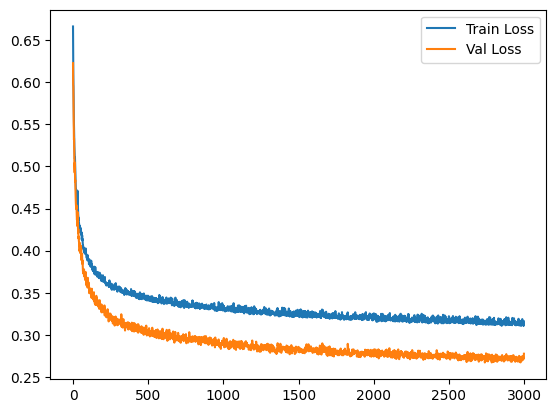

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

# Predict Phase

In [12]:
def predicted(model, loader):
  all_preds = []
  all_labels = []
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in loader:
      data = data.to(device)
      out = model(data)
      pred = (out > 0).float()
      correct += pred.eq(data.y).sum().item()
      total += data.y.numel()
      all_preds.append(pred.cpu().numpy())
      all_labels.append(data.y.cpu().numpy())
  accuracy = correct/total
  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)
  f1_macro = f1_score(all_labels, all_preds, average='macro')
  f1_micro = f1_score(all_labels, all_preds, average='micro')
  return accuracy, f1_macro, f1_micro

## Check the acuuracy and F1-score of the best model

In [13]:
ppi_model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
accuracy, f1_macro, f1_micro = predicted(ppi_model, test_loader)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 macro: {f1_macro:.4f}')
print(f'Test F1 micro: {f1_micro:.4f}')

Test Accuracy: 0.9110
Test F1 macro: 0.8189
Test F1 micro: 0.8408
